In [ ]:
!pip install huggingface_hub
!pip install transformers
!pip install datasets
!pip install sentence-transformers
!pip install imbalanced-learn

In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
import os
import re
import imblearn



#do not show warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
home_dir = '/home/jupyter/data_science_challenges/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')

df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

df = df.loc[df.Country == 'United Kingdom']

In [10]:
df.Description

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
401584         FAIRY TALE COTTAGE NIGHT LIGHT
401585    LARGE CAKE STAND  HANGING STRAWBERY
401586       SET OF 3 HANGING OWLS OLLIE BEAK
401587          RED RETROSPOT ROUND CAKE TINS
401588                  DOORMAT RED RETROSPOT
Name: Description, Length: 356728, dtype: object

In [3]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer
import torch
from datasets import load_dataset
import datasets

2024-02-23 20:13:08.140906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 20:13:08.141100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 20:13:08.595214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 20:13:10.122144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 20:13:24.654096: W tensorflow/compiler/tf2

In [4]:
huggingface_dataset_name = "bprateek/amazon_product_description"

# Download the dataset
ds = load_dataset(huggingface_dataset_name, split="train")

#Drop all but the following columns in mask
mask = ['Product Name','Category','Product Specification','Product Dimensions','Color']
ds = ds.remove_columns([c for c in ds.column_names if c not in mask])

# Create lables array and a dataframe of all the labels
cat = pd.DataFrame(ds['Category']).rename(columns={0:'Categories'})
cat = cat['Categories'].str.split('|', expand= True)
cat = cat.applymap(lambda x: x.strip() if x else None)

# Turn Apache Arrow dataset into pandas dataframe
ds = pd.DataFrame(ds)

## Joining together some deeply undersampled classes:

cat.loc[cat[0].isin(['Video Games','Movies & TV']), 0] = "Video Games, Movies & TV"
cat.loc[cat[0].isin(["Electronics",'Musical Instruments','Cell Phones & Accessories']), 0] = "Electronics, Musical Instruments, Cell Phones & Accessories"

labels = pd.DataFrame(cat.drop_duplicates().stack().drop_duplicates()).reset_index(drop=True)

# Rename columns
for i in cat.columns:
    ds[f'label_{i}'] = cat[i]
    
# LEts drop the unlabled instances from the dataset
ds =ds.drop(ds.loc[ds['label_0'].isna()].index)

In [5]:
# Set Baseline

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics

### Without Oversampling

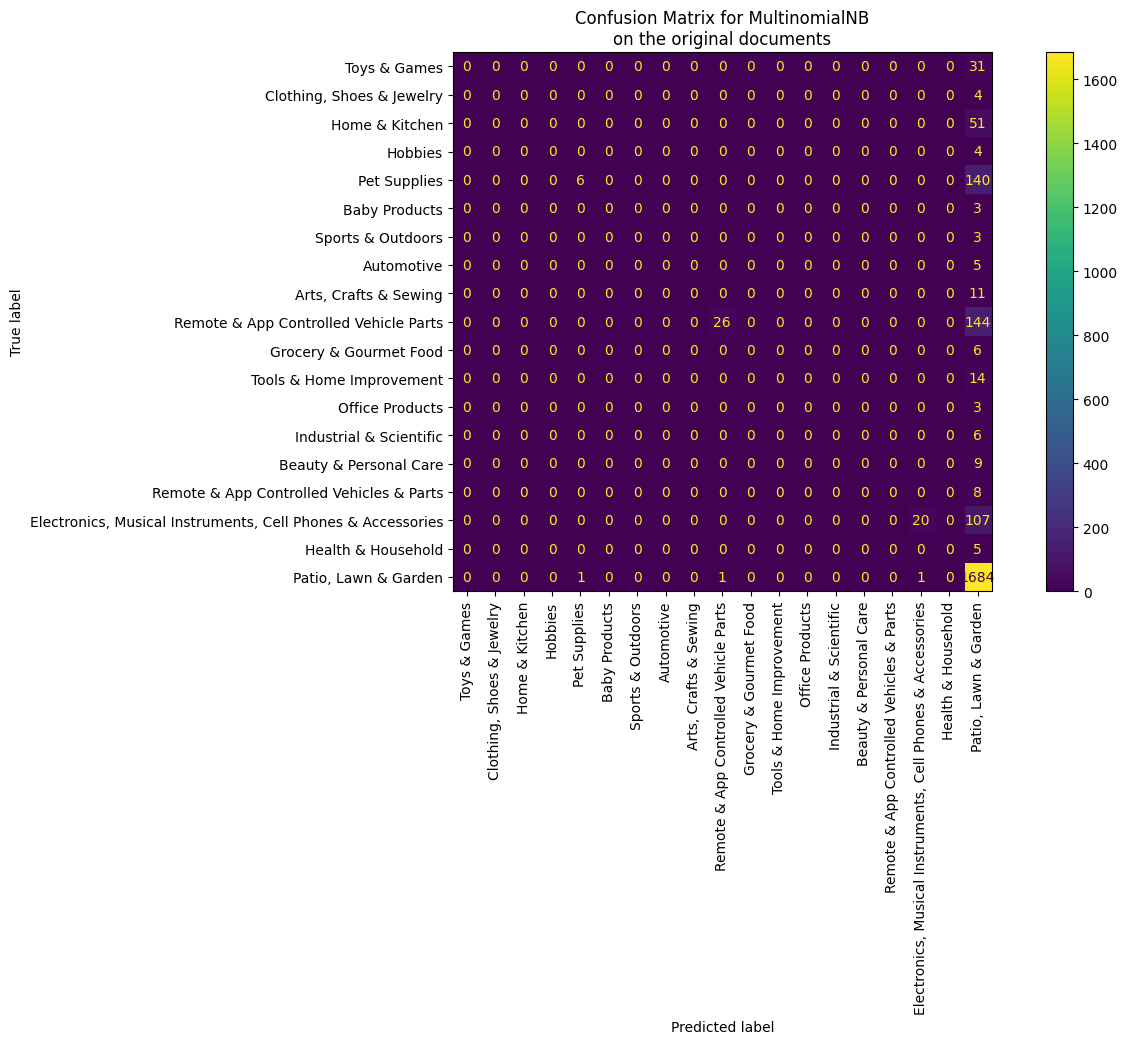

In [7]:
# Without Oversampling

count_vect = CountVectorizer()
X= count_vect.fit_transform(ds['Product Name'])

# Doing y
#y = count_vect.fit_transform(ds['label_0'])
count_vect.vocabulary_.get(u'algorithm')

# Transform the counts into a tf-idf representation
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)
#y_tfidf = tfidf_transformer.fit_transform(y)
y= ds['label_0']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #train_test_split(X_tfidf.toarray(), y_tfidf.toarray(), random_state=42)

# Model Fitting
clf = MultinomialNB()
fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(14, 7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(y_test.unique(), rotation=90)
ax.yaxis.set_ticklabels(y_test.unique())
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

### With undersampling

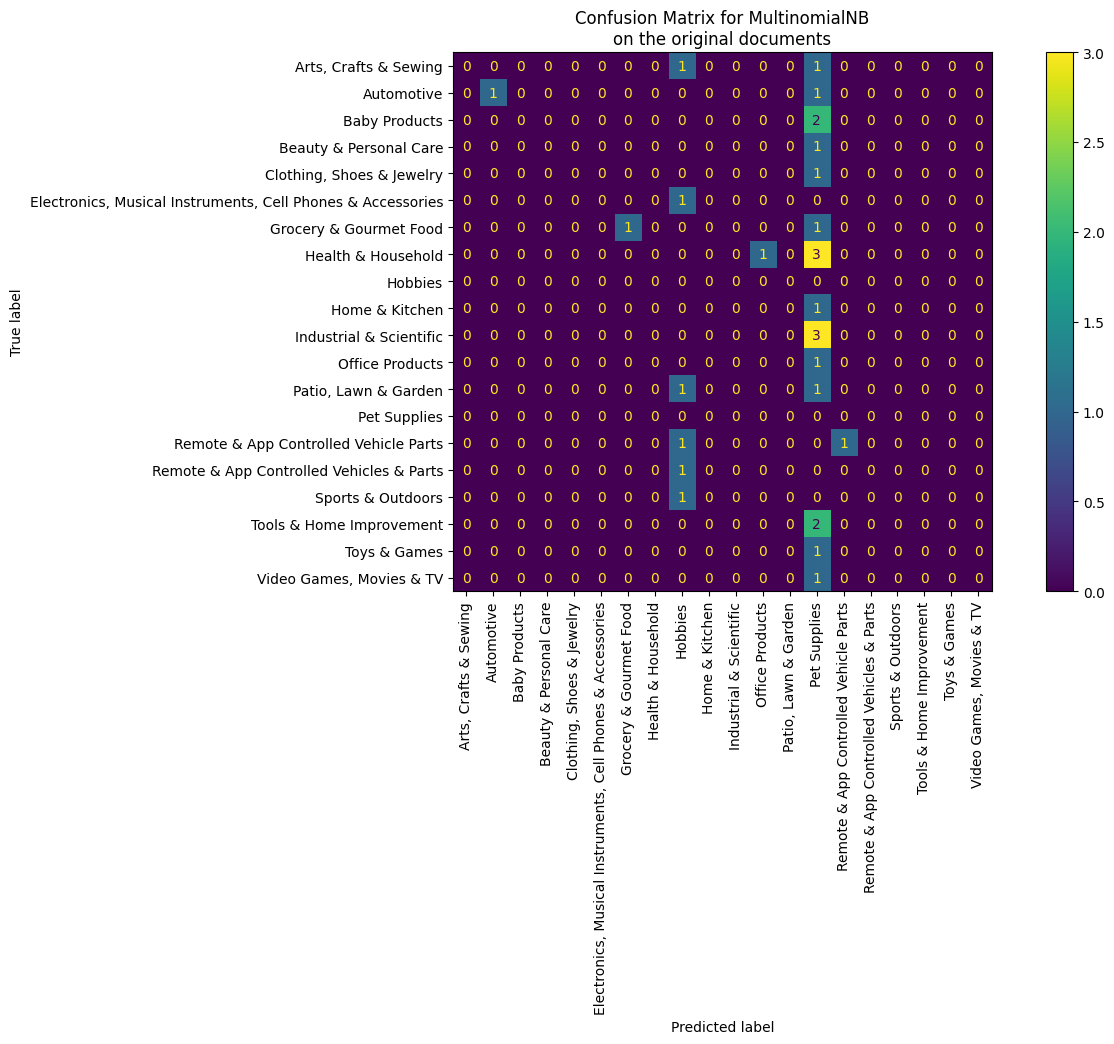

In [8]:
# Tokenize and vectorize X and y

# Doing X
count_vect = CountVectorizer()
X= count_vect.fit_transform(ds['Product Name'])

# Doing y
#y = count_vect.fit_transform(ds['label_0'])
count_vect.vocabulary_.get(u'algorithm')

# Transform the counts into a tf-idf representation
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)
#y_tfidf = tfidf_transformer.fit_transform(y)
y= ds['label_0']

# Undersample
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42) #train_test_split(X_tfidf.toarray(), y_tfidf.toarray(), random_state=42)

# Model Fitting
clf = MultinomialNB()
fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(14, 7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(np.unique(y), rotation=90)
ax.yaxis.set_ticklabels(np.unique(y))
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)


### With Oversampling

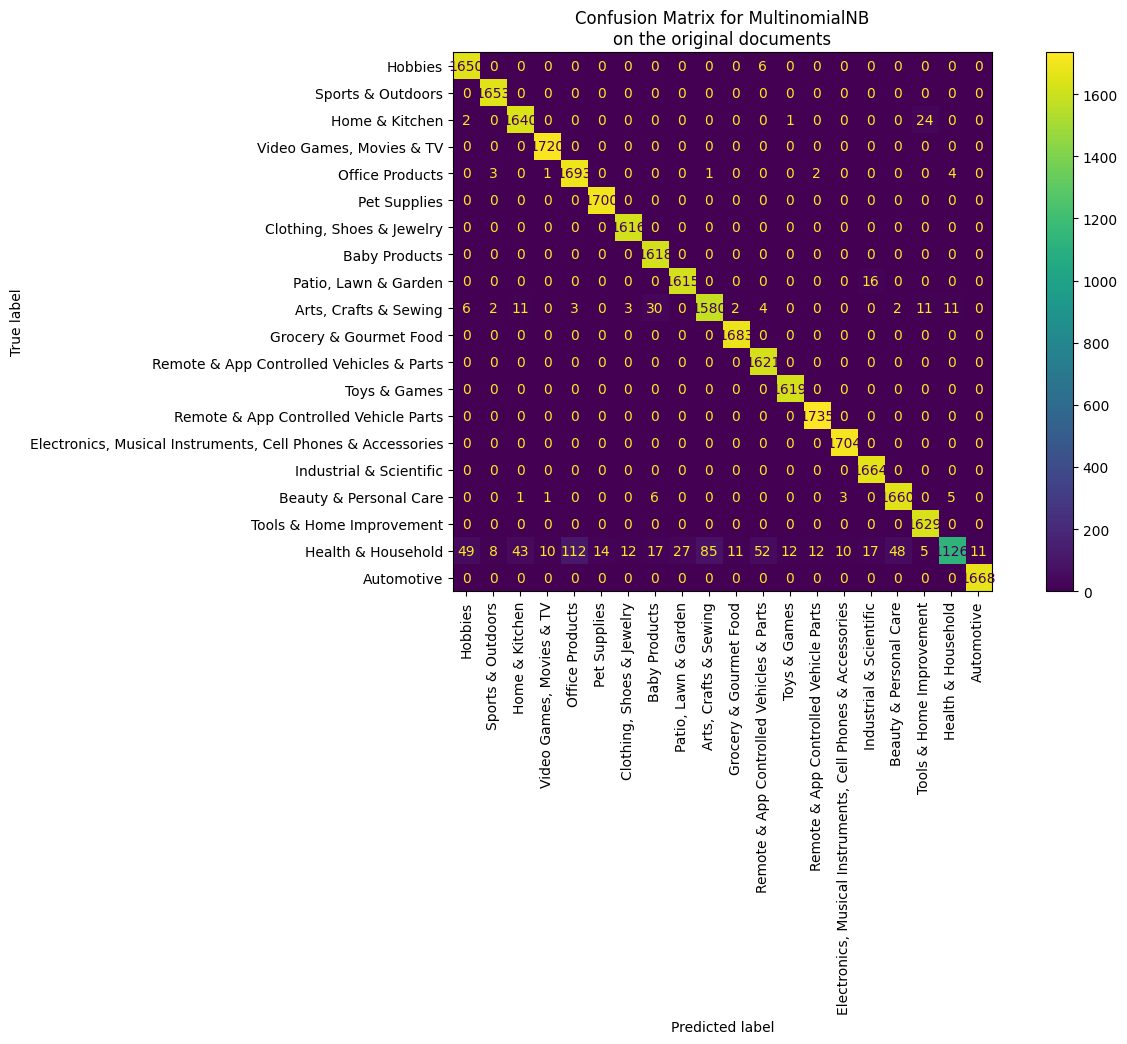

In [9]:
# Tokenize and vectorize X and y

# Doing X
count_vect = CountVectorizer()
X= count_vect.fit_transform(ds['Product Name'])

# Doing y
#y = count_vect.fit_transform(ds['label_0'])
count_vect.vocabulary_.get(u'algorithm')

# Transform the counts into a tf-idf representation
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)
#y_tfidf = tfidf_transformer.fit_transform(y)
y= ds['label_0']

# Oversample
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42) #train_test_split(X_tfidf.toarray(), y_tfidf.toarray(), random_state=42)

# Model Fitting
clf = MultinomialNB()
fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(14, 7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.xaxis.set_ticklabels(y_test.unique(), rotation=90)
ax.yaxis.set_ticklabels(y_test.unique())
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [11]:
ds['Product Name']

0        DB Longboards CoreFlex Crossbow 41" Bamboo Fib...
1        Electronic Snap Circuits Mini Kits Classpack, ...
2        3Doodler Create Flexy 3D Printing Filament Ref...
3        Guillow Airplane Design Studio with Travel Cas...
4                         Woodstock- Collage 500 pc Puzzle
                               ...                        
9997     Remedia Publications REM536B Money Activity Bo...
9998     Trends International NFL La Chargers HG - Mobi...
9999     NewPath Learning 10 Piece Science Owls and Owl...
10000             Disney Princess Do It Yourself Braid Set
10001          Hasegawa Ladders Lucano Step Ladder, Orange
Name: Product Name, Length: 9172, dtype: object

In [13]:
X = ds['Product Name']
#y_tfidf = tfidf_transformer.fit_transform(y)
y= ds['label_0']

# Oversample
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X, y)

In [45]:
ds.label_0.value_counts()

label_0
Toys & Games                                                   6662
Home & Kitchen                                                  708
Clothing, Shoes & Jewelry                                       630
Sports & Outdoors                                               540
Baby Products                                                   214
Arts, Crafts & Sewing                                           124
Office Products                                                  77
Hobbies                                                          34
Industrial & Scientific                                          29
Health & Household                                               23
Remote & App Controlled Vehicle Parts                            22
Remote & App Controlled Vehicles & Parts                         17
Tools & Home Improvement                                         17
Pet Supplies                                                     16
Patio, Lawn & Garden                    

In [ ]:
### Using an LLM

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
model_name = "facebook/bart-large-mnli"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)
#tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = cat[0].unique().tolist()

In [30]:
ds['Product Name'].unique()

array(['DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete',
       'Electronic Snap Circuits Mini Kits Classpack, FM Radio, Motion Detector, Music Box (Set of 5)',
       "3Doodler Create Flexy 3D Printing Filament Refill Bundle (X5 Pack, Over 1000'. of Extruded Plastics! - Innovate",
       ...,
       'NewPath Learning 10 Piece Science Owls and Owl Pellets Curriculum Mastery Flip Chart Set, Grade 5-9',
       'Disney Princess Do It Yourself Braid Set',
       'Hasegawa Ladders Lucano Step Ladder, Orange'], dtype=object)

In [17]:
classifier(ds['Product Name'][4], labels, multi_label=False)

{'sequence': 'Woodstock- Collage 500 pc Puzzle',
 'labels': ['Hobbies',
  'Remote & App Controlled Vehicle Parts',
  'Toys & Games',
  'Remote & App Controlled Vehicles & Parts',
  'Electronics, Musical Instruments, Cell Phones & Accessories',
  'Industrial & Scientific',
  'Office Products',
  'Sports & Outdoors',
  'Arts, Crafts & Sewing',
  'Video Games, Movies & TV',
  'Automotive',
  'Patio, Lawn & Garden',
  'Health & Household',
  'Pet Supplies',
  'Home & Kitchen',
  None,
  'Tools & Home Improvement',
  'Beauty & Personal Care',
  'Baby Products',
  'Grocery & Gourmet Food',
  'Clothing, Shoes & Jewelry'],
 'scores': [0.10510260611772537,
  0.07512268424034119,
  0.07034893333911896,
  0.06632767617702484,
  0.05996297672390938,
  0.05349249020218849,
  0.05263642966747284,
  0.04775700718164444,
  0.04627619683742523,
  0.04517175629734993,
  0.042177144438028336,
  0.040736302733421326,
  0.03942365199327469,
  0.03892204910516739,
  0.03754356503486633,
  0.0355790145695209

### Using the dataset

In [79]:
desc = pd.DataFrame(df['Description'].drop_duplicates().copy().reset_index(drop=True))
desc["Description"] = desc.apply(lambda row: re.sub(r'[^A-Za-z0-9]+', ' ', row['Description']), axis=1) 
#desc['tokenized_description'] = desc.apply(lambda row: tokenizer.tokenize(row['Description']), axis=1)

desc = desc[:10]

labels = cat[0].unique().tolist()

#from textblob import TextBlob

#desc['tokenized_description'] = desc.apply(lambda row: TextBlob(row['Description']).ngrams(2), axis=1)

#for c in labels:
#    desc[c] = pd.Series(dtype="string")

In [ ]:
### Using an LLM

In [86]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
model_name = "facebook/bart-large-mnli"
classifier = pipeline("zero-shot-classification", model=model_name, device=device)
#tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [87]:
desc["Classification"] = desc.apply(lambda row : classifier(row['Description'], labels, multi_label=True), axis=1) 

In [88]:
desc["First Guess"] = desc.apply(lambda row : row['Classification']['labels'][0], axis=1)
desc["Second Guess"] = desc.apply(lambda row : row['Classification']['labels'][1], axis=1)
desc["Third Guess"] = desc.apply(lambda row : row['Classification']['labels'][2], axis=1)
desc["First Guess Score"] = desc.apply(lambda row : row['Classification']['scores'][0], axis=1)
desc["Second Guess Score"] = desc.apply(lambda row : row['Classification']['scores'][1], axis=1)
desc["Third Guess Score"] = desc.apply(lambda row : row['Classification']['scores'][2], axis=1)

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

def preprocess(txt):
    sent = nltk.word_tokenize(txt)
    sent = nltk.pos_tag(txt)
    return txt

In [7]:
text = "WHITE HANGING HEART T LIGHT HOLDER"
preprocess(text)

[('WHITE', 'NNP'),
 ('HANGING', 'NNP'),
 ('HEART', 'NNP'),
 ('T', 'NNP'),
 ('LIGHT', 'NNP'),
 ('HOLDER', 'NNP')]

In [89]:
desc

,Description,Classification,First Guess,Second Guess,Third Guess,First Guess Score,Second Guess Score,Third Guess Score
0,WHITE HANGING HEART T LIGHT HOLDER,{'sequence': 'WHITE HANGING HEART T LIGHT HOLD...,Hobbies,Health & Household,Home & Kitchen,0.299852,0.073629,0.065469
1,WHITE METAL LANTERN,"{'sequence': 'WHITE METAL LANTERN', 'labels': ...",Industrial & Scientific,"Patio, Lawn & Garden",Automotive,0.399121,0.340450,0.072497
2,CREAM CUPID HEARTS COAT HANGER,"{'sequence': 'CREAM CUPID HEARTS COAT HANGER',...",Tools & Home Improvement,Health & Household,Beauty & Personal Care,0.592459,0.434603,0.384519
3,KNITTED UNION FLAG HOT WATER BOTTLE,{'sequence': 'KNITTED UNION FLAG HOT WATER BOT...,Home & Kitchen,Health & Household,"Arts, Crafts & Sewing",0.883806,0.675030,0.484251
4,RED WOOLLY HOTTIE WHITE HEART,"{'sequence': 'RED WOOLLY HOTTIE WHITE HEART ',...",Health & Household,Hobbies,"Video Games, Movies & TV",0.302542,0.134390,0.129251
5,SET 7 BABUSHKA NESTING BOXES,"{'sequence': 'SET 7 BABUSHKA NESTING BOXES', '...",Baby Products,Pet Supplies,Sports & Outdoors,0.884666,0.371912,0.113617
6,GLASS STAR FROSTED T LIGHT HOLDER,{'sequence': 'GLASS STAR FROSTED T LIGHT HOLDE...,Home & Kitchen,Beauty & Personal Care,Hobbies,0.422669,0.247123,0.179558
7,HAND WARMER UNION JACK,"{'sequence': 'HAND WARMER UNION JACK', 'labels...",Industrial & Scientific,Tools & Home Improvement,Hobbies,0.200611,0.095496,0.086667
8,HAND WARMER RED POLKA DOT,"{'sequence': 'HAND WARMER RED POLKA DOT', 'lab...",Automotive,Industrial & Scientific,Sports & Outdoors,0.975106,0.224829,0.188275
9,ASSORTED COLOUR BIRD ORNAMENT,"{'sequence': 'ASSORTED COLOUR BIRD ORNAMENT', ...",Industrial & Scientific,Sports & Outdoors,Beauty & Personal Care,0.146388,0.117705,0.112967


In [39]:
def classify(text, labels, tokenizer):
    #list of outputs that will contain squence, lables, and scores
    output_list = []
    #Looping over tokenized words in text/record and appending
    for token in text:
        output = classifier(token, labels, multi_label=True)
        output_list.append(output) 
    return output_list

In [ ]:
def get_row_descriptor(record,):

    color, shape, size, decoration_type, material_type, product_type = [],[],[],[],[],[]

    for element in record:
        if element['labels'][0] == 'color':
            color.append(element['sequence'])
        if element['labels'][0] == 'shape':
            shape.append(element['sequence'])
        if element['labels'][0] == 'size':
            size.append(element['sequence'])
        if element['labels'][0] == 'decoration type':
            decoration_type.append(element['sequence'])
        if element['labels'][0] == 'material type':
            material_type.append(element['sequence'])
        if element['labels'][0] == 'product type':
            product_type.append(element['sequence'])
        
    return {"color": color,
            "shape": shape,
            "size": size, 
            "decoration type": decoration_type,
            "material type": material_type, 
            "product type": product_type}

In [ ]:
#classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

candidate_labels = labels

desc_df2 = desc.iloc[0:3].copy()

desc_df2["Classification"] = desc_df2.apply(lambda row : classify(row['tokenized_description'], candidate_labels, tokenizer), axis=1) 

In [ ]:
desc_df2["descriptor"] = desc_df2.apply(lambda row : get_row_descriptor(row['Classification']), axis=1)
kwargs = {"color" : lambda x: x["descriptor"].map(lambda y: y["color"]),
          "shape" : lambda x: x["descriptor"].map(lambda y: y["shape"]),
          "size" : lambda x: x["descriptor"].map(lambda y: y["size"]),
          "decoration type" : lambda x: x["descriptor"].map(lambda y: y["decoration type"]),
          "material type" : lambda x: x["descriptor"].map(lambda y: y["material type"]),
          "product type" : lambda x: x["descriptor"].map(lambda y: y["product type"])}

desc_df2.assign(**kwargs)

In [ ]:
### Results suck.  Lets try some PEFT/LORA

In [ ]:
desc_df2.Classification[0]